# Get FF_Estimation MSDCV

Make sure that analysis_estimation_nds.py imports FF_estimation, and that batch_size = 100 in model_settings.py.

In [1]:
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import analysis_estimation_nds
import importlib
importlib.reload(analysis_estimation_nds)
from jupyterthemes import jtplot
jtplot.style()
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

['/home/sychen23/.local/lib/python3.5/site-packages/ipykernel_launcher.py', '-f', '/home/sychen23/.local/share/jupyter/runtime/kernel-00625fcf-566a-4eb0-b4a9-f16f6e814205.json', 'true', 'true', 'true', 'true', 'true', 'model_runs/-f/classify_log.csv', 'model_runs/-f/classifymodel_0.ckpt', 'model_runs/-f/classifymodel_', 'model_runs/-f/zzzdraw_data_5000.npy', 'false', 'true', 'false', 'false', 'true']
hidden_w: Tensor("Placeholder_1:0", shape=(225, 250), dtype=float32)
hidden_b: Tensor("Placeholder_2:0", shape=(250,), dtype=float32)
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use `argmax` instead
FF_estimation_classifier_swap
analysis_estimation_nds.py
FF_estimation_classifier_swap
analysis_estimation_nds.py


In [2]:
models = [("CAA_const_fN", "Swap Classifier, Const Avg Area, $f(n)$ Constant"),
          ("CAA_decrs_fN", "Swap Classifier, Const Avg Area, $f(n) \propto 1/n^2$"),
          ("DAA_const_fN", "Swap Classifier, Decr Avg Area, $f(n)$ Constant"),
          ("DAA_decrs_fN", "Swap Classifier, Decr Avg Area, $f(n) \propto 1/n^2$")]
model = models[0]
mode, model_figure_title = model
model_name = "estimation/swap_test/swap_classifier_" + mode
num_runs = 10
iter_list = [0, 200, 400, 1600, 6400, 25600, 102400, 204800, 409600, 819200, 1000000, 1228800, 1638400, 2000000, 3000000]#, 4000000, 5000000, 6000000]
train_max_blobs = 15
test_max_blobs = 9
train_min_blobs = test_min_blobs = 1

num_iters = len(iter_list)
train_output_size = train_max_blobs - train_min_blobs + 1
test_output_size = test_max_blobs - test_min_blobs + 1
test_condition = "po_ind"
incremental = False
data_directory = "data/" + model_name + "/" + test_condition + "/"

import os
if not os.path.exists(data_directory):
    os.makedirs(data_directory)
    
from pathlib import Path
results_dir = 'Results/20200709_msdcv_3000000_classifier/confidence_msdcv/' + test_condition + "/"
Path(results_dir+'estimation/swap_test/').mkdir(parents=True, exist_ok=True)
scalar = False
choice = False

In [3]:
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
import os
path = 'model_runs/' + model_name + '_run' + str(1)
it = 0
checkpoint_path = "%s/classifymodel_%d.ckpt" % (path, it)

# List ALL tensors example output: v0/Adam (DT_FLOAT) [3,3,1,80]
print_tensors_in_checkpoint_file(file_name=checkpoint_path, tensor_name='', all_tensors=False, all_tensor_names=False)

# List contents of v0 tensor.
# Example output: tensor_name:  v0 [[[[  9.27958265e-02   7.40226209e-02   4.52989563e-02   3.15700471e-02
# print_tensors_in_checkpoint_file(file_name=checkpoint_path, tensor_name='hidden/b', all_tensors=False, all_tensor_names=False)


beta1_power (DT_FLOAT) []
beta2_power (DT_FLOAT) []
output/b (DT_FLOAT) [15]
output/b/Adam (DT_FLOAT) [15]
output/b/Adam_1 (DT_FLOAT) [15]
output/w (DT_FLOAT) [250,15]
output/w/Adam (DT_FLOAT) [250,15]
output/w/Adam_1 (DT_FLOAT) [250,15]



### Test out loading swap checkpoints

In [4]:
MODE = "DAA_const_fN"
swap_index = 3000000
test_run = 0
swap_file = "model_runs/estimation/scalar_model/scalar_"+MODE+"_run"+str(test_run+1)+"/classifymodel_" + str(swap_index) + ".ckpt"
print_tensors_in_checkpoint_file(file_name=swap_file, tensor_name='', all_tensors=False, all_tensor_names=False)
import tensorflow as tf
ckpt_reader = tf.train.load_checkpoint(swap_file)
hidden_w = ckpt_reader.get_tensor("hidden/w")
hidden_b = ckpt_reader.get_tensor("hidden/b")
hidden_w.shape, hidden_b.shape

beta1_power (DT_FLOAT) []
beta2_power (DT_FLOAT) []
hidden/b (DT_FLOAT) [250]
hidden/b/Adam (DT_FLOAT) [250]
hidden/b/Adam_1 (DT_FLOAT) [250]
hidden/w (DT_FLOAT) [225,250]
hidden/w/Adam (DT_FLOAT) [225,250]
hidden/w/Adam_1 (DT_FLOAT) [225,250]
output/b (DT_FLOAT) [1]
output/b/Adam (DT_FLOAT) [1]
output/b/Adam_1 (DT_FLOAT) [1]
output/w (DT_FLOAT) [250,1]
output/w/Adam (DT_FLOAT) [250,1]
output/w/Adam_1 (DT_FLOAT) [250,1]



((225, 250), (250,))

In [5]:
tf.all_variables()

Instructions for updating:
Please use tf.global_variables instead.


[<tf.Variable 'output/w:0' shape=(250, 15) dtype=float32_ref>,
 <tf.Variable 'output/b:0' shape=(15,) dtype=float32_ref>,
 <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'output/w/Adam:0' shape=(250, 15) dtype=float32_ref>,
 <tf.Variable 'output/w/Adam_1:0' shape=(250, 15) dtype=float32_ref>,
 <tf.Variable 'output/b/Adam:0' shape=(15,) dtype=float32_ref>,
 <tf.Variable 'output/b/Adam_1:0' shape=(15,) dtype=float32_ref>]

In [6]:
test_run = 0
path = 'model_runs/' + model_name + '_run' + str(test_run+1)
imgs_data = analysis_estimation_nds.classify_imgs_po_swap(2000000, True, 100, mode, test_run, path=path, incremental=incremental, scalar=scalar)
print(np.shape(imgs_data[0]['label']))
print(imgs_data[0]['label'])
print(imgs_data[0]['classifications'][0]) # softmax output

INFO:tensorflow:Restoring parameters from model_runs/estimation/swap_test/swap_classifier_CAA_const_fN_run1/classifymodel_2000000.ckpt
(9,)
[0. 0. 0. 1. 0. 0. 0. 0. 0.]
[4.2532380e-11 5.1176682e-04 7.7902541e-02 1.9974628e-01 4.7960073e-01
 1.8344578e-01 3.9359916e-02 1.6493848e-02 2.8645776e-03 7.3109310e-05
 1.4183493e-06 1.4604168e-08 9.9139849e-11 7.6977780e-13 4.4301872e-16]


In [7]:
def get_classifications_one_run(mode, test_run, path, iteration):
    """Get classifications for one run at one iteration."""
    imgs_data = analysis_estimation_nds.classify_imgs_po_swap(iteration, True, 100, mode, test_run, path=path, incremental=incremental, scalar=scalar)
    confidence_one_run = np.zeros([train_output_size, train_output_size])
    choice_one_run = np.zeros([train_output_size, train_output_size])

    for nb in range(test_output_size): 
        num_blobs = nb + test_min_blobs
        confidence_hist = np.zeros(train_output_size)
        choice_hist = np.zeros(train_output_size)
        num_imgs_with_num_blobs = 0.00001

        for idx, data in enumerate(imgs_data):
            if data["label"][nb] == 1: # data is for an image with num_blobs blobs
                num_imgs_with_num_blobs += 1

                # Histogram of softmaxes
                confidence_hist += np.array(data["classifications"][0])

                # Histogram of choices
                choice = np.argmax(data["classifications"][0])
                choice_list = [0] * train_output_size
                choice_list[choice] = 1
                choice_hist += choice_list

        confidence_hist = confidence_hist / num_imgs_with_num_blobs
        confidence_one_run[nb] = confidence_hist.tolist()
        choice_hist = choice_hist / num_imgs_with_num_blobs
        choice_one_run[nb] = choice_hist.tolist()
    return confidence_one_run, choice_one_run

In [8]:
confidence_all_runs = np.zeros([num_runs, num_iters, train_output_size, train_output_size]) 
choice_all_runs = np.zeros([num_runs, num_iters, train_output_size, train_output_size])
for run in range(num_runs):
    path = 'model_runs/' + model_name + '_run' + str(run + 1) # '/run_' if all the runs are stored in one folder
    for i, iteration in enumerate(iter_list):
        confidence_all_runs[run, i], choice_all_runs[run, i] = get_classifications_one_run(mode, run, path, iteration)

np.save(data_directory + "confidence_hist", confidence_all_runs)
np.save(data_directory + "choice_hist", choice_all_runs)

INFO:tensorflow:Restoring parameters from model_runs/estimation/swap_test/swap_classifier_CAA_const_fN_run1/classifymodel_0.ckpt
INFO:tensorflow:Restoring parameters from model_runs/estimation/swap_test/swap_classifier_CAA_const_fN_run1/classifymodel_200.ckpt
INFO:tensorflow:Restoring parameters from model_runs/estimation/swap_test/swap_classifier_CAA_const_fN_run1/classifymodel_400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/estimation/swap_test/swap_classifier_CAA_const_fN_run1/classifymodel_1600.ckpt
INFO:tensorflow:Restoring parameters from model_runs/estimation/swap_test/swap_classifier_CAA_const_fN_run1/classifymodel_6400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/estimation/swap_test/swap_classifier_CAA_const_fN_run1/classifymodel_25600.ckpt
INFO:tensorflow:Restoring parameters from model_runs/estimation/swap_test/swap_classifier_CAA_const_fN_run1/classifymodel_102400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/estimation/swap_test/swap

INFO:tensorflow:Restoring parameters from model_runs/estimation/swap_test/swap_classifier_CAA_const_fN_run5/classifymodel_400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/estimation/swap_test/swap_classifier_CAA_const_fN_run5/classifymodel_1600.ckpt
INFO:tensorflow:Restoring parameters from model_runs/estimation/swap_test/swap_classifier_CAA_const_fN_run5/classifymodel_6400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/estimation/swap_test/swap_classifier_CAA_const_fN_run5/classifymodel_25600.ckpt
INFO:tensorflow:Restoring parameters from model_runs/estimation/swap_test/swap_classifier_CAA_const_fN_run5/classifymodel_102400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/estimation/swap_test/swap_classifier_CAA_const_fN_run5/classifymodel_204800.ckpt
INFO:tensorflow:Restoring parameters from model_runs/estimation/swap_test/swap_classifier_CAA_const_fN_run5/classifymodel_409600.ckpt
INFO:tensorflow:Restoring parameters from model_runs/estimation/swap_t

INFO:tensorflow:Restoring parameters from model_runs/estimation/swap_test/swap_classifier_CAA_const_fN_run9/classifymodel_6400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/estimation/swap_test/swap_classifier_CAA_const_fN_run9/classifymodel_25600.ckpt
INFO:tensorflow:Restoring parameters from model_runs/estimation/swap_test/swap_classifier_CAA_const_fN_run9/classifymodel_102400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/estimation/swap_test/swap_classifier_CAA_const_fN_run9/classifymodel_204800.ckpt
INFO:tensorflow:Restoring parameters from model_runs/estimation/swap_test/swap_classifier_CAA_const_fN_run9/classifymodel_409600.ckpt
INFO:tensorflow:Restoring parameters from model_runs/estimation/swap_test/swap_classifier_CAA_const_fN_run9/classifymodel_819200.ckpt
INFO:tensorflow:Restoring parameters from model_runs/estimation/swap_test/swap_classifier_CAA_const_fN_run9/classifymodel_1000000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/estimation/

In [9]:
def get_msdcv(hist_matrix):
    """Get the mean, standard deviation, and coefficient of variation matrices from histogram matrix."""
    
    msdcv = np.zeros([num_runs, num_iters, train_output_size, 3])
    
    for run in range(num_runs):
        for i, it in enumerate(iter_list):
            for t in range(train_output_size):
                values_sum = 0
                sqr_sum = 0

                # Find the mean
                for p in range(train_output_size):
                    values_sum += (p + 1) * hist_matrix[run, i, t, p]
                msdcv[run, i, t, 0] = mu = values_sum

                # Find the standard deviation
                for p in range(train_output_size):
                    sqr_sum += (p + 1 - mu)**2 * hist_matrix[run, i, t, p]
                msdcv[run, i, t, 1] = sigma = np.sqrt(sqr_sum)

                # Find the coefficient of variation
                msdcv[run, i, t, 2] = cv = sigma / mu
    return np.mean(msdcv, axis=0)

In [10]:
confidence_msdcv = get_msdcv(confidence_all_runs)
choice_msdcv = get_msdcv(choice_all_runs)

In [11]:
np.save(data_directory + "confidence_msdcv", confidence_msdcv)
np.save(data_directory + "choice_msdcv", choice_msdcv)

## Visualize Mean, Standard Deviation, and Coefficient of Variation

Run 20200202_Plot_MSDCV_scalar.ipynb to get plots. Below is an example plot.

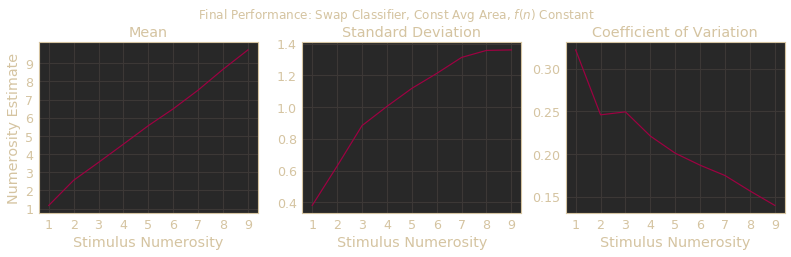

In [12]:
all_iters = iter_list
iters = [3000000]
iter_indices = [i for i, iteration in enumerate(all_iters) if iteration in iters]
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(3.7*3, 3.6))
from matplotlib.ticker import MaxNLocator
plt.xticks(np.arange(test_min_blobs, test_max_blobs+1, step=1))
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))
numerosity = np.arange(test_min_blobs, test_max_blobs+1)

ax[0].set_title("Mean")
ax[0].set_xlabel("Stimulus Numerosity")
ax[0].set_ylabel("Numerosity Estimate")
ax[0].set_yticks(np.arange(test_min_blobs, test_max_blobs+1, step=1))
ax[0].set_xticks(np.arange(test_min_blobs, test_max_blobs+1, step=1))
ax[0].set_prop_cycle('color',plt.cm.Spectral([val for val in np.linspace(0,1,len(iter_indices)) for _ in (0,1)]))

ax[1].set_title("Standard Deviation")
ax[1].set_xlabel("Stimulus Numerosity")
ax[1].set_xticks(np.arange(test_min_blobs, test_max_blobs+1, step=1))
ax[1].set_prop_cycle('color',plt.cm.Spectral([val for val in np.linspace(0,1,len(iter_indices)) for _ in (0,1)]))

ax[2].set_title("Coefficient of Variation")
ax[2].set_xlabel("Stimulus Numerosity")
# ax[2].set_yticks(np.arange(0, 1, step=0.02))
ax[2].set_xticks(np.arange(test_min_blobs, test_max_blobs+1, step=1))
ax[2].set_prop_cycle('color',plt.cm.Spectral([val for val in np.linspace(0,1,len(iter_indices)) for _ in (0,1)]))

for i in iter_indices:
    mean = confidence_msdcv[i,test_min_blobs-1:test_max_blobs,0]
    sd = confidence_msdcv[i,test_min_blobs-1:test_max_blobs,1]
    cv = confidence_msdcv[i,test_min_blobs-1:test_max_blobs,2]

    # Plot Mean.
    ax[0].plot(numerosity, mean, label='N')
    
    # Plot SD.
    ax[1].plot(numerosity, sd, label='N')
    
    # Plot CV.
    ax[2].plot(numerosity, cv, label='N')

fig.tight_layout()
fig.suptitle("Final Performance: %s" % model_figure_title)
plt.tight_layout(rect=[0, 0, 1, 0.95])
from pathlib import Path
plt.savefig(results_dir + model_name + '.png')
plt.show()

In [13]:
iter_indices

[14]

In [14]:
choice_msdcv.shape

(15, 15, 3)